## Model Training ##

The second part of our project is about training models to estimate scoring and conceding probabilities, and deriving the action values from those.

First we will load the data. If you have not already you should run the 1_Loading_Data.ipynb file to retrieve the data and save it to a file, so that it can be loaded here.

In [35]:
import shap
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df_model = pd.read_pickle("data/data_cleaned.pkl")

### Encoding ###

Some classification algorithms like logistic regression require us to encode categorical columns like action_type or body_part. So we will do this via one-hot encoding.

In [36]:
body_part_dummies = pd.get_dummies(df_model['body_part_name'], prefix='body_part_name')
action_type_dummies = pd.get_dummies(df_model['action_type'], prefix='action_type')
result_dummies = pd.get_dummies(df_model['result'], prefix='result')

df_model = pd.concat([df_model, body_part_dummies, action_type_dummies, result_dummies], axis=1)

### Estimating Probabilities ###

#### Logistic Regression ####

Now we can train our first logistic regression model to try and predict the two labels based on our features.

In [37]:
features = ['distance_to_goal', 'angle_to_goal', 'time_elapsed', 'period']

target = 'label_team_goal'

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

y_prob_all = model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

coefficients = model.coef_[0]

coeff_df = pd.DataFrame(coefficients, columns=["Coefficient"], index=features)
print(coeff_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    221588
           1       0.48      0.01      0.02      2320

    accuracy                           0.99    223908
   macro avg       0.73      0.50      0.51    223908
weighted avg       0.98      0.99      0.98    223908

ROC AUC Score: 0.781919088890037
                  Coefficient
distance_to_goal    -0.037609
angle_to_goal        0.038969
time_elapsed         0.000112
period              -0.067981


And analogously the same for the conceding probabilities.

In [38]:
target_opponent = 'label_opponent_goal'

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(X_opp, y_opp, test_size=0.5, stratify=y_opp)

model_opp = LogisticRegression()
model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))

print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))

y_prob_all_opp = model_opp.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_concede_prob'] = y_prob_all_opp

coefficients_opp = model_opp.coef_[0]
coeff_opp_df = pd.DataFrame(coefficients_opp, index=features, columns=["Coefficient"])
print(coeff_opp_df)

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223508
           1       1.00      0.00      0.00       400

    accuracy                           1.00    223908
   macro avg       1.00      0.50      0.50    223908
weighted avg       1.00      1.00      1.00    223908

ROC AUC Score (Conceding Goals): 0.7007634737906473
                  Coefficient
distance_to_goal     0.041601
angle_to_goal        0.063367
time_elapsed         0.000102
period              -0.159451


#### XGBoost ####

Since some of the features are non-linear, XGBoost will probably perform better.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    221589
           1       0.79      0.01      0.01      2319

    accuracy                           0.99    223908
   macro avg       0.89      0.50      0.50    223908
weighted avg       0.99      0.99      0.98    223908

ROC AUC Score: 0.7933364891044872


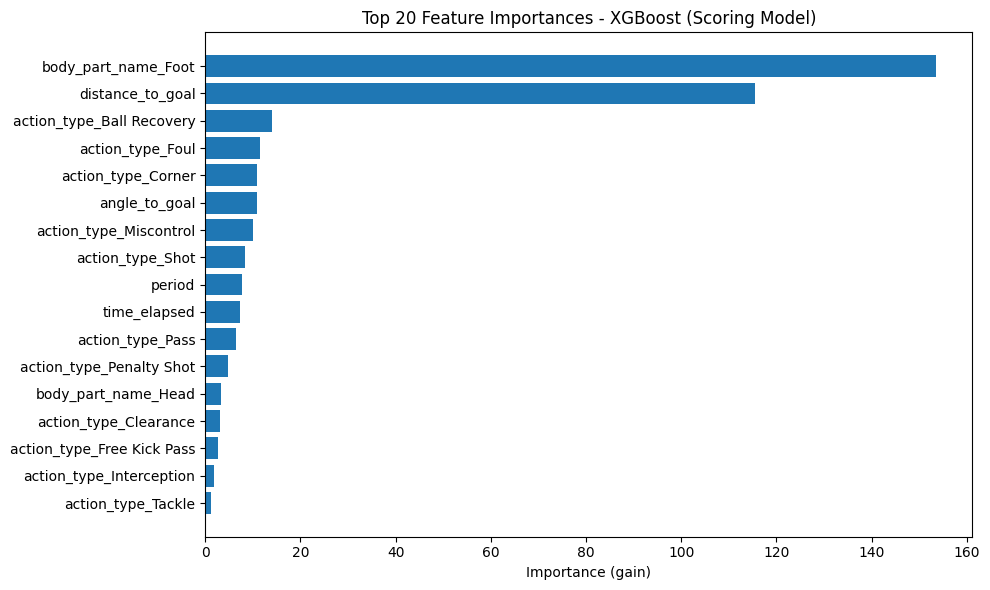

In [39]:
features = ['distance_to_goal', 'angle_to_goal', 'time_elapsed', 'period',
        'body_part_name_Foot', 'body_part_name_Head', 'body_part_name_Other',
        'action_type_Ball Recovery', 'action_type_Carry',
        'action_type_Clearance', 'action_type_Corner', 'action_type_Foul',
        'action_type_Free Kick Pass', 'action_type_Free Kick Shot',
        'action_type_Goal Kick', 'action_type_Interception',
        'action_type_Miscontrol', 'action_type_Own Goal', 'action_type_Pass',
        'action_type_Penalty Shot', 'action_type_Shot', 'action_type_Tackle',
        'action_type_Throw In']

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

y_prob_all = xgb_model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
importance_df = importance_df.reset_index().rename(columns={'index': 'feature'})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:20][::-1], importance_df['importance'][:20][::-1])
plt.xlabel('Importance (gain)')
plt.title('Top 20 Feature Importances - XGBoost (Scoring Model)')
plt.tight_layout()
plt.show()

And analogously for the conceding probabilities.

In [40]:
df_model = df_model.dropna(subset=features + [target_opponent])

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(
    X_opp, y_opp, test_size=0.5, stratify=y_opp
)

model_opp = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))
print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))

df_model = df_model.copy()
df_model['predicted_concede_prob'] = model_opp.predict_proba(X_opp)[:, 1]

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223508
           1       0.00      0.00      0.00       400

    accuracy                           1.00    223908
   macro avg       0.50      0.50      0.50    223908
weighted avg       1.00      1.00      1.00    223908

ROC AUC Score (Conceding Goals): 0.8174582285645258


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Extended Features ##

Now the same with all features.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    221589
           1       1.00      0.11      0.20      2319

    accuracy                           0.99    223908
   macro avg       1.00      0.56      0.60    223908
weighted avg       0.99      0.99      0.99    223908

ROC AUC Score: 0.817023703804664


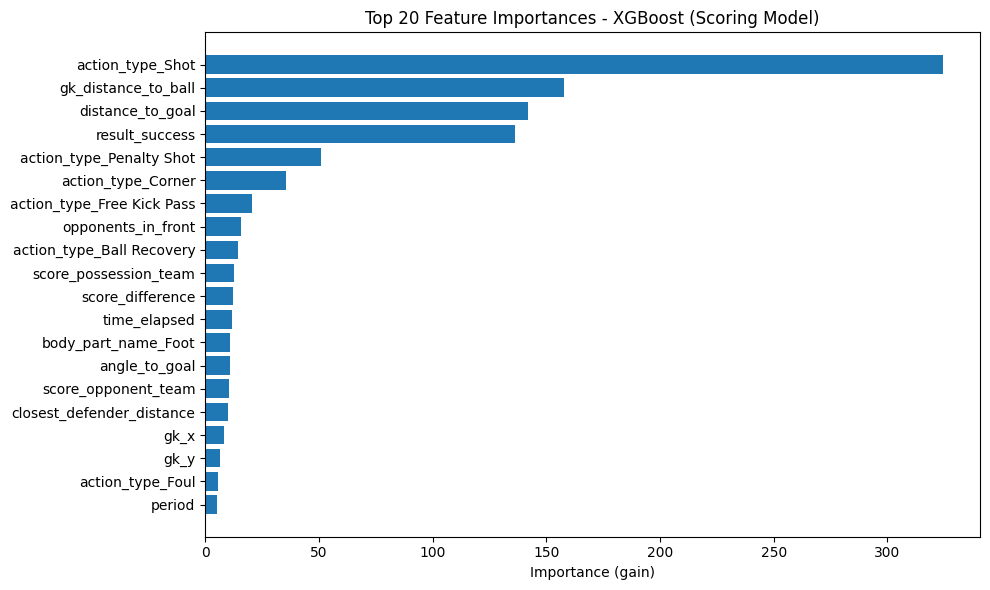

In [41]:
features = ['distance_to_goal', 'angle_to_goal', 'time_elapsed', 'period',
        'body_part_name_Foot', 'body_part_name_Head', 'body_part_name_Other',
        'action_type_Ball Recovery', 'action_type_Carry',
        'action_type_Clearance', 'action_type_Corner', 'action_type_Foul',
        'action_type_Free Kick Pass', 'action_type_Free Kick Shot',
        'action_type_Goal Kick', 'action_type_Interception',
        'action_type_Miscontrol', 'action_type_Own Goal', 'action_type_Pass',
        'action_type_Penalty Shot', 'action_type_Shot', 'action_type_Tackle',
        'action_type_Throw In', 'closest_defender_distance', 'opponents_in_front',
        'gk_x', 'gk_y', 'gk_distance_to_ball', 'gk_in_shooting_triangle', 
        'gk_in_penalty_area', 'score_possession_team', 'score_opponent_team',
        'score_difference', 'result_fail', 'result_offside', 'result_owngoal',
        'result_success']

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

y_prob_all = xgb_model.predict_proba(df_model[features])[:, 1]
df_model = df_model.copy()
df_model['predicted_goal_prob'] = y_prob_all

importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
importance_df = importance_df.reset_index().rename(columns={'index': 'feature'})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:20][::-1], importance_df['importance'][:20][::-1])
plt.xlabel('Importance (gain)')
plt.title('Top 20 Feature Importances - XGBoost (Scoring Model)')
plt.tight_layout()
plt.show()

And here are the shapley values because they look cool as fuck.

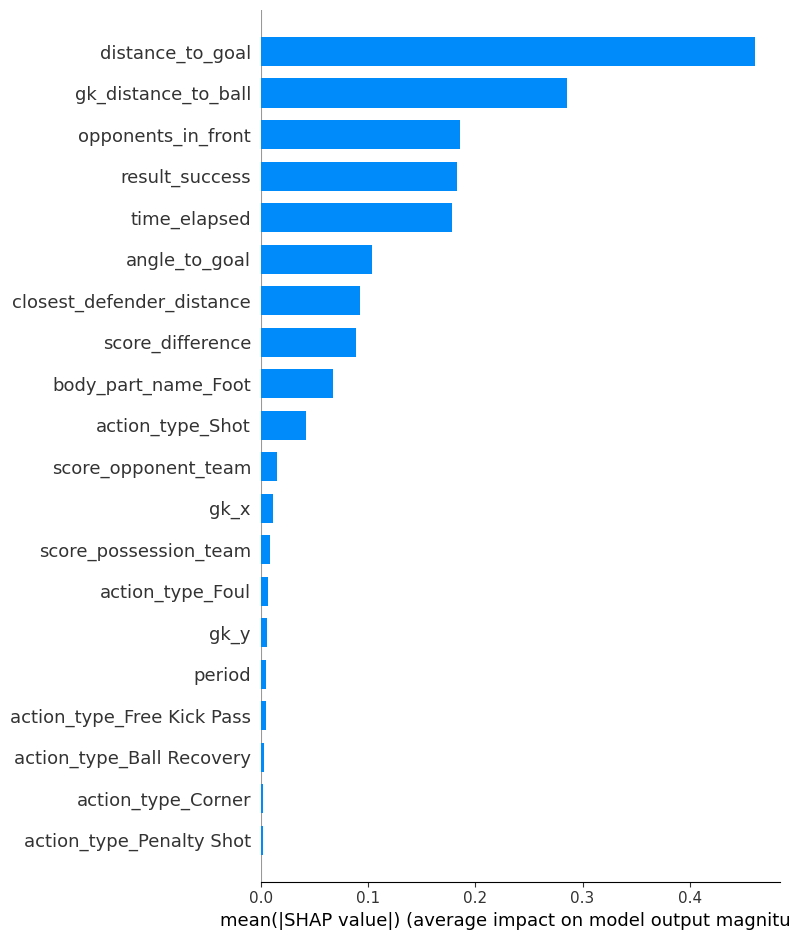

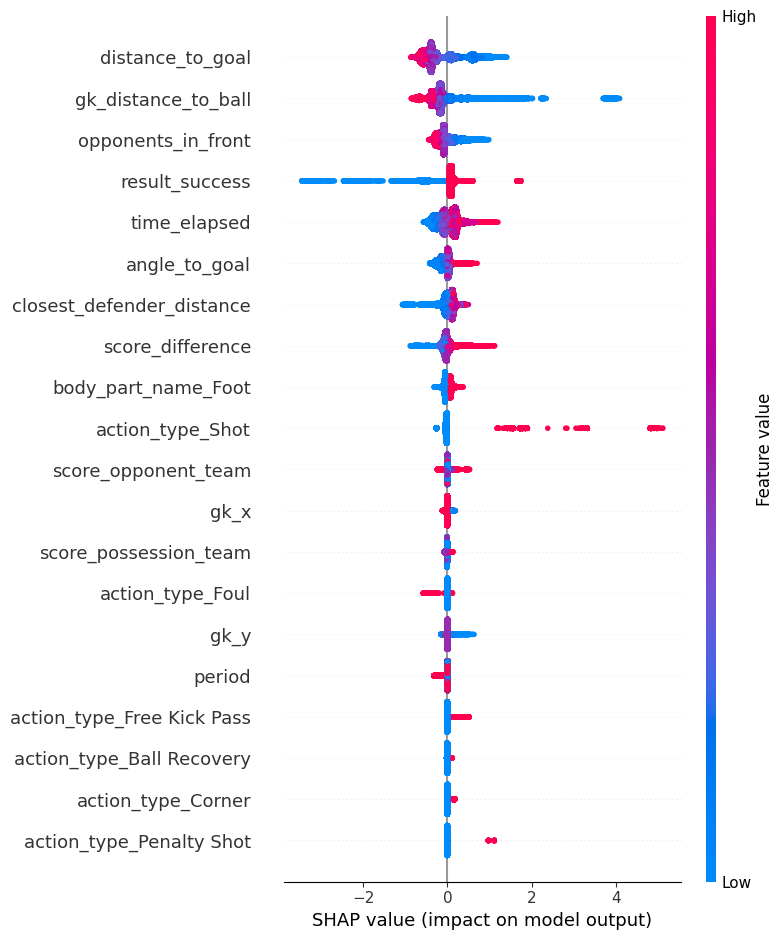

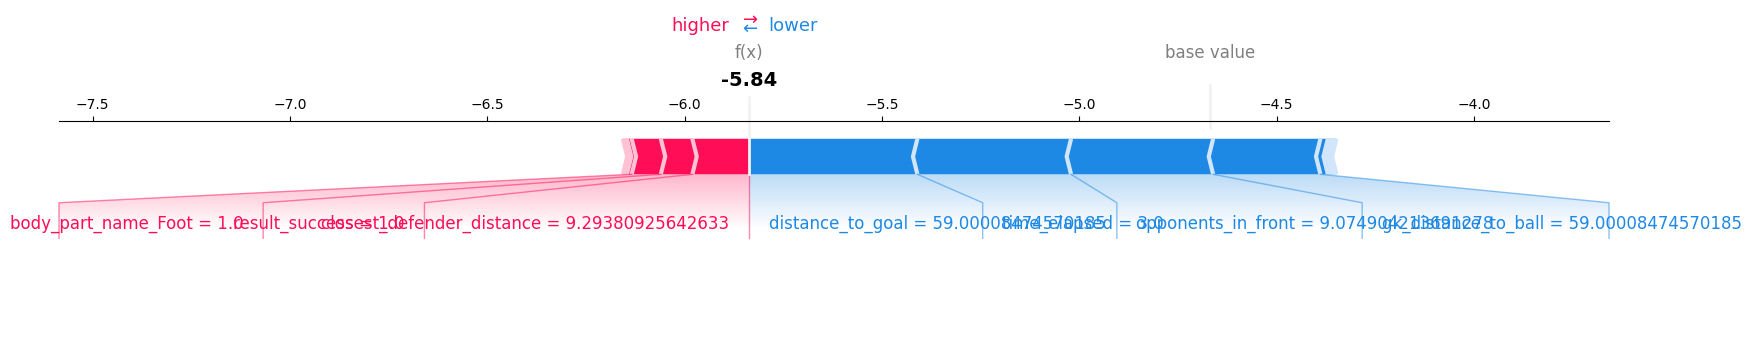

In [42]:
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X)

plt.figure()
shap.summary_plot(shap_values, X, plot_type='bar')
plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()

shap.summary_plot(shap_values, X)

index = 0
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X.iloc[index],
    matplotlib=True
)

And for conceding probabilities.

In [43]:
df_model = df_model.dropna(subset=features + [target_opponent])

X_opp = df_model[features]
y_opp = df_model[target_opponent]

X_train_opp, X_test_opp, y_train_opp, y_test_opp = train_test_split(
    X_opp, y_opp, test_size=0.5, stratify=y_opp
)

model_opp = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

model_opp.fit(X_train_opp, y_train_opp)

y_pred_opp = model_opp.predict(X_test_opp)
y_prob_opp = model_opp.predict_proba(X_test_opp)[:, 1]

print("Classification Report (Conceding Goals):")
print(classification_report(y_test_opp, y_pred_opp))
print("ROC AUC Score (Conceding Goals):", roc_auc_score(y_test_opp, y_prob_opp))

df_model = df_model.copy()
df_model['predicted_concede_prob'] = model_opp.predict_proba(X_opp)[:, 1]

Classification Report (Conceding Goals):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223508
           1       1.00      0.04      0.07       400

    accuracy                           1.00    223908
   macro avg       1.00      0.52      0.53    223908
weighted avg       1.00      1.00      1.00    223908

ROC AUC Score (Conceding Goals): 0.8616272963383862


### Computing Action Values ###

Now we can calculate the action value as the sum of differences in scoring and conceding probabilities between subsequent game states. We need to consider two special cases though:

1. When a shot ends up in a goal the next state value will be set to 1. Works analogously for an own goal.
2. When possession changes after an action, the probabilities are switched in the next state, because the scoring and conceding probabilities always        correspond to the team performing the action.

In [44]:
df_model['action_value'] = 0.0

for match_id, df_match in df_model.groupby('match_id', sort=False):
    idxs = df_match.index.to_list()

    for i in range(len(idxs) - 1):
        idx_current = idxs[i]
        idx_next = idxs[i + 1]

        current_team = df_model.at[idx_current, 'team_id']
        next_team = df_model.at[idx_next, 'team_id']

        score_curr = df_model.at[idx_current, 'predicted_goal_prob']
        concede_curr = df_model.at[idx_current, 'predicted_concede_prob']

        score_next = df_model.at[idx_next, 'predicted_goal_prob']
        concede_next = df_model.at[idx_next, 'predicted_concede_prob']

        goal_scored = (
            df_model.at[idx_current, 'type_name'] == 'Shot' and
            df_model.at[idx_current, 'outcome_name'] == 'Goal'
        )

        own_goal_scored = (
            df_model.at[idx_current, 'type_name'] == 'Own Goal Against'
        )

        if goal_scored:
            score_next = 1.0
            concede_next = 0.0
        elif own_goal_scored:
            score_next = 0.0
            concede_next = 1.0

        if next_team != current_team and not goal_scored and not own_goal_scored:
            score_next, concede_next = concede_next, score_next

        delta_score = score_next - score_curr
        delta_concede = concede_curr - concede_next
        action_value = delta_score + delta_concede

        df_model.at[idx_current, 'action_value'] = action_value

In [45]:
df_model.to_pickle("data/data_cleaned_trained.pkl")

We can now rank players according to their cumulated action values. However we need to normalize the action values to per 90 minutes to make the ranking fair. To do this we need to get the playing time of each player in the dataset.

In [46]:
player_minutes = pd.read_pickle("data/player_minutes.pkl")

top_players_df = df_model.groupby(['player_id', 'player_name'])['action_value'].sum().reset_index()

top_players_df = top_players_df.merge(
    player_minutes[['player_id', 'minutes_played']],
    on='player_id',
    how='left'
)

MIN_MINUTES = 270
top_players_df = top_players_df[top_players_df['minutes_played'] >= MIN_MINUTES]
top_players_df['action_value_per90'] = top_players_df['action_value'] / (top_players_df['minutes_played'] / 90)

top_players_df = top_players_df.sort_values(by='action_value_per90', ascending=False)
print(top_players_df[['player_name', 'action_value_per90']].head(30))

                                  player_name  action_value_per90
1508              Lamine Yamal Nasraoui Ebana            0.931441
872                                Paul Pogba            0.667479
612                             Jack Grealish            0.621004
233            Lionel Andrés Messi Cuccittini            0.586281
1419                               Arda Güler            0.585077
52                            Marcus Rashford            0.577330
489                                Ritsu Doan            0.576076
849   Vinícius José Paixão de Oliveira Júnior            0.553273
235                       Jens Stryger Larsen            0.529920
829                           Vladimír Coufal            0.528122
189                          Jordi Alba Ramos            0.518118
708                                David Raum            0.499209
771                             Donyell Malen            0.497581
175                 Salem Mohammed Al Dawsari            0.488059
547       